## 1. Introduction
<p><a href="https://commons.wikimedia.org/wiki/File:Tux.svg">
<img style="float: right;margin:5px 20px 5px 1px" width="150px" src="https://assets.datacamp.com/production/project_111/img/tux.png" alt="Tux: la mascota de Linux">
</a></p>
<p>Los repositorios de control de versiones como CVS, Subversion o Git pueden ser una verdadera mina de oro para los desarrolladores de software. Contienen cada cambio realizado al código fuente, incluyendo la fecha (el "cuándo"), el desarrollador responsable (el "quién"), así como un pequeño mensaje que describe la intención (el "qué") de un cambio.</p>
<p>En este cuaderno, analizaremos la evolución de un proyecto de código abierto muy famoso: el kernel de Linux. El kernel de Linux es el corazón de algunas distribuciones de Linux como Debian, Ubuntu o CentOS. Nuestro conjunto de datos contiene el historial del desarrollo del kernel durante casi 13 años (principios de 2005 - finales de 2017). Obtendremos información sobre el trabajo de los esfuerzos de desarrollo mediante:</p>
<ul>
<li>Identificar a los 10 principales contribuyentes </li>
<li>Visualizar los commits a lo largo de los años.</li>
</ul>

In [96]:
#Importación de Librerías Necesarias
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [97]:
# Printing the content of git_log_excerpt.csv
# Importar la Data - separador - cabecera - nombre de columnas 
df = pd.read_csv("datasets/git_log_excerpt.csv",sep="#",header=None,names=["timestamp","author"])
# Diez Principales contribuyentes
display(df.head(10))

,timestamp,author
0,1502382966,Linus Torvalds
1,1501368308,Max Gurtovoy
2,1501625560,James Smart
3,1501625559,James Smart
4,1500568442,Martin Wilck
5,1502273719,Xin Long
6,1502278684,Nikolay Borisov
7,1502238384,Girish Moodalbail
8,1502228709,Florian Fainelli
9,1502223836,Jon Paul Maloy


## 2. Reading in the dataset
<p>El conjunto de datos fue creado utilizando el comando <code>git log --encoding=latin-1 --pretty="%at#%aN"</code> a finales de 2017. La salida de texto codificada en <code>latin-1</code> se guardó en un archivo CSV sin encabezado. En este archivo, cada fila es una entrada de commit con la siguiente información:</p>
<ul>
<li><code>timestamp</code>: la hora del commit como una marca de tiempo UNIX en segundos desde 1970-01-01 00:00:00 (Marcador de posición de Git log "<code>%at</code>")</li>
<li><code>author</code>: el nombre del autor que realizó el commit (Marcador de posición de Git log "<code>%aN</code>")</li>
</ul>
<p>Las columnas están separadas por el signo de número <code>#</code>. El conjunto de datos completo se encuentra en el directorio <code>datasets/</code>. Es un archivo csv comprimido en <code>gz</code> llamado <code>git_log.gz</code>.</p>

In [98]:
# Leyendo el archivo
git_log = pd.read_csv("datasets/git_log_data.csv")

# Imprimiendo los 5 primeros registros
git_log.head()

,timestamp,author
0,1502826583,Linus Torvalds
1,1501749089,Adrian Hunter
2,1501749088,Adrian Hunter
3,1501882480,Kees Cook
4,1497271395,Rob Clark


## 3. Obteniendo una visión general
<p>El conjunto de datos contiene información sobre cada contribución de código (un "commit") al kernel de Linux en los últimos 13 años. Primero echaremos un vistazo al número de autores y sus commits en el repositorio.</p>

In [99]:
# Cada Registro es un commit así que solo tomamos el largo del dataframe
number_of_commits = len(git_log)

# Calculamos el número de autores unicos
number_of_authors = git_log["author"].nunique()

# Imprimimos los Resultados. 
print("%s authors committed %s code changes." % (number_of_authors, number_of_commits))

17385 authors committed 699071 code changes.


## 4. Encontrando los 10 principales contribuyentes
<p>Existen algunas personas muy importantes que han realizado cambios frecuentes en el kernel de Linux. Para ver si hay algún cuello de botella, vamos a analizar a los 10 principales autores con más commits.</p>

In [100]:
# Identificamos por conteo a los 10 autores con mayor cantidad de commits. 
top_10_authors = git_log["author"].value_counts().head(10)

# Listamos a los 10 autores como resultado
top_10_authors

Linus Torvalds           23361
David S. Miller           9106
Mark Brown                6802
Takashi Iwai              6209
Al Viro                   6006
H Hartley Sweeten         5938
Ingo Molnar               5344
Mauro Carvalho Chehab     5204
Arnd Bergmann             4890
Greg Kroah-Hartman        4580
Name: author, dtype: int64

## 5. Manipulando los datos
<p>Para nuestro análisis, queremos visualizar las contribuciones a lo largo del tiempo. Para esto, utilizaremos la información en la columna <code>timestamp</code> para crear una columna basada en series de tiempo.</p>

In [101]:
# Convertimos esta columna a una de tipo fecha, sus unidades eran segundos desde 01-01-1970.
git_log["timestamp"] = pd.to_datetime(git_log["timestamp"],unit="s")
# Hacemos un resumen del DataFrame anterior. 
git_log.describe()

,timestamp,author
count,699071,699070
unique,668448,17385
top,2008-09-04 05:30:19,Linus Torvalds
freq,99,23361
first,1970-01-01 00:00:01,NaN
last,2037-04-25 08:08:26,NaN


## 6. Tratando los timestamps incorrectos
<p>Como podemos ver en los resultados anteriores, algunos contribuyentes tenían incorrectamente configurada la hora de su sistema operativo cuando realizaron los commits en el repositorio. Vamos a limpiar la columna <code>timestamp</code> eliminando las filas con timestamps incorrectos.</p>

In [102]:
# Filtramos solo los commits que existen registrados desde el inicio del 2005
commit_2005_more = git_log[git_log["timestamp"] >= pd.to_datetime("2005")]
# Obtenemos el Primer Commit obteniendo la fecha mínima
first_commit_timestamp = commit_2005_more["timestamp"].min()
# El Limite superior de las fechas para los commit sera el año 2018
last_commit_timestamp = pd.to_datetime("2018")
#Obtenemos solo los commits validos
corrected_log = git_log[(git_log["timestamp"] >= first_commit_timestamp) #Mayor al Primer Commit
                        & (git_log["timestamp"] <= last_commit_timestamp)] #Menor al Límite del 2018
#Obtenemos un Resumen del DataFrame Filtrado
corrected_log.describe()


,timestamp,author
count,699035,699034
unique,668424,17384
top,2008-09-04 05:30:19,Linus Torvalds
freq,99,23361
first,2005-01-06 21:16:45,NaN
last,2017-10-03 12:57:00,NaN


## 7. Agrupando los commits por año
<p>Para determinar cómo ha aumentado la actividad de desarrollo a lo largo del tiempo, vamos a agrupar los commits por año y contarlos.</p>

In [103]:
#Si existe un author nulo este es nombrado como "Unknown" para que sea contado. 
corrected_log["author"] = corrected_log["author"].fillna("Unknown")
#Agrupar por Años mediante un dato tipo fecha
commit_per_year = corrected_log.groupby(
    pd.Grouper(key="timestamp",freq="AS") #Recibe la columna fecha y la frecuencia con la que debemos agrupar. 
).count()
commit_per_year

,author
timestamp,
2005-01-01,16696
2006-01-01,29255
2007-01-01,33759
2008-01-01,48847
2009-01-01,52572
2010-01-01,49819
2011-01-01,56403
2012-01-01,65389
2013-01-01,71001


## 8. Visualizando la historia de Linux
<p>Finalmente, crearemos un gráfico a partir de estos recuentos para poder visualizar mejor cómo ha aumentado el esfuerzo de desarrollo en Linux en los últimos años.</p>

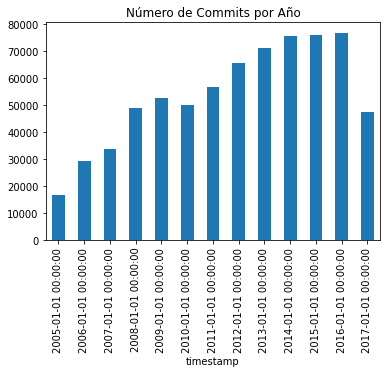

In [104]:
#Gráfico de Barras según los Commits que se hicieron durante los años.
commit_per_year.plot(kind="bar",legend=False,title="Número de Commits por Año") #KIND es TIPO de GRÁFICO
plt.show()

## 9. Conclusión
<p>Gracias a la sólida base y al cuidado de Linux Torvalds, muchos otros desarrolladores ahora también pueden contribuir al kernel de Linux. ¡No se observa una disminución de la actividad de desarrollo a la vista!</p>

In [105]:
# Cambiamos el nombre de la columna a "n_commits" osea numeros de commits. 
commit_per_year.columns = ["n_commits"]
#Ordenamos los registros de mayor a menor y el primer indice sería el año con mayor cant. de commits. 
year_with_most_commits = commit_per_year["n_commits"].sort_values(ascending=False).index[0]
print(year_with_most_commits.year)

2016
